In [85]:
import pandas as pd
import numpy as np
import ast
!pwd

import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt

# plt.style.use('QC_publication')
# sns.axes_style("darkgrid")
# This just tells Jupyter to plot our figures as output using the widget
%matplotlib inline 
# if matplotlib widget is not installed (it makes the plot interactive) you can use %matplotlib inline instead for static plots
matplotlib.matplotlib_fname()

# Get the current font family from rcParams
font_family = plt.rcParams['font.family']
print(f"Current font family: {font_family}")

/exports/csce/datastore/geos/users/s2135982/rivertools/mlfluv/script


'/exports/csce/datastore/geos/users/s2135982/miniconda/envs/LSDTTtest/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'

In [86]:
data_path = '../exp_data_fixed.csv'

df = pd.read_csv(data_path)

df[['log_num', 'tune_log_num']] = df[['log_num', 'tune_log_num']].astype(int)

# Convert the 'Class wise IoU' column back to list of floats instead of a string
df['Class wise IoU'] = df['Class wise IoU'].apply(ast.literal_eval) 
print(df['Class wise IoU'][1])

# print(df['Class wise IoU'].head(2))

[0.0, 0.9153899427117973, 0.7031360852307287, 0.837030225375603, 0.0, 0.0, 0.45408872468718164]


In [87]:
df.sort_values(by=['log_num', 'tune_log_num', 'distill_lamda', 'temperature'])

,log_num,which_label,weights,tune_log_num,distill_lamda,temperature,Mean IoU,Micro IoU,Macro IoU,Accuracy,Precision,Class wise IoU
1,1001,ESRI,inverse_log,1,0.0,1.0,0.416,0.844,0.411,0.976,0.915,"[0.0, 0.9153899427117973, 0.7031360852307287, ..."
12,1001,ESRI,inverse_log,2,0.0,0.1,0.417,0.842,0.415,0.976,0.914,"[0.0, 0.9121360515726024, 0.6953245169129865, ..."
19,1001,ESRI,inverse_log,3,0.0,0.5,0.444,0.846,0.470,0.976,0.916,"[0.0, 0.9077670208339034, 0.6848213113587478, ..."
20,1001,ESRI,inverse_log,4,0.0,2.0,0.475,0.842,0.484,0.975,0.914,"[0.0, 0.907280026633164, 0.6814200014903627, 0..."
21,1001,ESRI,inverse_log,5,0.0,10.0,0.414,0.835,0.407,0.974,0.910,"[0.0, 0.9042994055254706, 0.6743109920929218, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
144,3002,ESAWC,inverse_count,22,1.0,1.0,0.214,0.638,0.220,0.937,0.779,"[0.0, 0.7392220616340637, 0.012683488835845592..."
145,3002,ESAWC,inverse_count,23,1.0,0.1,0.142,0.583,0.144,0.925,0.737,"[0.0, 0.7094986907367049, 0.06104952320456505,..."
146,3002,ESAWC,inverse_count,24,1.0,0.5,0.171,0.599,0.174,0.928,0.749,"[0.0, 0.7144840577553059, 0.00619892331065032,..."
147,3002,ESAWC,inverse_count,25,1.0,2.0,0.233,0.685,0.243,0.947,0.813,"[0.0, 0.8011895085203237, 0.2519480292139382, ..."


In [88]:
# Define class names and their corresponding indices
class_names = ['tree IoU', 'short vegetation IoU', 'water IoU', 'urban IoU', 'bare ground IoU', 'fluvial sediment IoU']

# Function to extract IoU values for each class
def extract_iou_values(iou_list):
    result = {}
    for i, class_name in enumerate(class_names, start=1):
        if i < len(iou_list):
            result[class_name] = iou_list[i]
        else:
            result[class_name] = np.nan
    return result

# Apply the function to each row and create new columns
iou_values = df['Class wise IoU'].apply(extract_iou_values)
iou_df = pd.DataFrame(iou_values.tolist())

# Concatenate the original DataFrame with the new columns
df = pd.concat([df, iou_df], axis=1)

# rename Mean IoU to mean IoU
df.rename(columns={'Mean IoU': 'mean IoU', 'distill_lamda':'distill lamda'}, inplace=True)
df

,log_num,which_label,weights,tune_log_num,distill lamda,temperature,mean IoU,Micro IoU,Macro IoU,Accuracy,Precision,Class wise IoU,tree IoU,short vegetation IoU,water IoU,urban IoU,bare ground IoU,fluvial sediment IoU
0,1001,ESRI,inverse_log,25,1.00,10.0,0.499,0.868,0.492,0.976,0.929,"[0.0, 0.9252935384881907, 0.7428742435471765, ...",0.925294,0.742874,0.872361,0.000000,0.451173,NaN
1,1001,ESRI,inverse_log,1,0.00,1.0,0.416,0.844,0.411,0.976,0.915,"[0.0, 0.9153899427117973, 0.7031360852307287, ...",0.915390,0.703136,0.837030,0.000000,0.000000,0.454089
2,1001,ESRI,inverse_log,10,0.25,10.0,0.372,0.832,0.375,0.974,0.908,"[0.0, 0.90312027150187, 0.6674637578684708, 0....",0.903120,0.667464,0.848046,0.000000,0.001176,0.182621
3,1001,ESRI,inverse_log,11,0.50,1.0,0.341,0.823,0.340,0.972,0.903,"[0.0, 0.8951115119046178, 0.6533844988921593, ...",0.895112,0.653384,0.840803,0.000000,0.000000,0.000063
4,1001,ESRI,inverse_log,12,0.50,0.1,0.341,0.822,0.342,0.972,0.902,"[0.0, 0.8889798908398069, 0.6502622844844029, ...",0.888980,0.650262,0.849794,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,3002,ESAWC,inverse_count,5,0.00,2.0,0.349,0.787,0.368,0.966,0.881,"[0.0, 0.8706197290584958, 0.6349860273558517, ...",0.870620,0.634986,0.688871,0.250086,0.000000,0.000000
152,3002,ESAWC,inverse_count,6,0.00,10.0,0.359,0.787,0.385,0.966,0.881,"[0.0, 0.8707560633790904, 0.6186940267168243, ...",0.870756,0.618694,0.669829,0.354786,0.000000,0.000000
153,3002,ESAWC,inverse_count,7,0.25,1.0,0.214,0.643,0.220,0.938,0.782,"[0.0, 0.7471071362495423, 0.03593445863446285,...",0.747107,0.035934,0.714304,0.000000,0.000000,0.000041
154,3002,ESAWC,inverse_count,8,0.25,0.1,0.194,0.636,0.193,0.936,0.777,"[0.0, 0.7568607507080868, 0.21632032959625638,...",0.756861,0.216320,0.381568,0.000000,0.000000,0.000006


In [89]:
# Select rows where 'fluvial sediment' IoU is NaN
init_df = df[df['fluvial sediment IoU'].isna()]

# Update 'tune_log_num' to 0 for these selected rows to represent these models are the initial models
df.loc[init_df.index, 'tune_log_num'] = 0
df.loc[init_df.index, 'temperature'] = 1
df.loc[init_df.index, 'distill lamda'] = 0

# Check errors in tune log number, temperature and lamda
df_label = df[df['which_label']=='DW'].sort_values(by=['log_num', 'tune_log_num', 'distill lamda', 'temperature'])
# df_label[['log_num', 'tune_log_num', 'distill lamda', 'temperature', 'Mean IoU']]


In [90]:
# Fix the tune log number jump from 0 to 2. The correct version should be 0 to 25 continuous intergers
# Check if 1 is missing in the 'tune_log_num' column

def fix_tune_log_jump(log_number:int):
    df_log_number = df[df['log_num'] == log_number]

    if 1 not in df_log_number['tune_log_num'].values:
        # Shift values 2-26 to 1-25 in the filtered dataframe
        df_log_number.loc[df_log_number['tune_log_num'] > 1, 'tune_log_num'] -= 1
        # Update the original dataframe with the modified values
        df.loc[df['log_num'] == log_number, 'tune_log_num'] = df_log_number['tune_log_num']

fix_tune_log_jump(2002)
fix_tune_log_jump(3001)
fix_tune_log_jump(3002)

# Display the dataframe
# print(df[df['log_num']==3001])

In [91]:
# Find best models of both initial train and fine tune
best_miou_idx = df.groupby('which_label')['mean IoU'].idxmax()
best_mIoU_param = df.loc[best_miou_idx].sort_values(by=['log_num'])
# print(best_model_param)
print(best_mIoU_param[['log_num', 'tune_log_num', 'distill lamda', 'temperature', 'mean IoU', 'water IoU', 'bare ground IoU', 'fluvial sediment IoU']])

     log_num  tune_log_num  distill lamda  temperature  mean IoU  water IoU  \
26      1002             0            0.0          1.0     0.542   0.835017   
78      2002             0            0.0          1.0     0.464   0.853746   
104     3001             0            0.0          1.0     0.411   0.824797   

     bare ground IoU  fluvial sediment IoU  
26          0.375404                   NaN  
78          0.291854                   NaN  
104         0.000000                   NaN  


In [92]:
# Find best models of fine tune only
# Exclude the initial trained models
filtered_df = df[~df['fluvial sediment IoU'].isna()]

best_miou_idx = filtered_df.groupby('which_label')['mean IoU'].idxmax()
best_mIoU_param = filtered_df.loc[best_miou_idx].sort_values(by=['log_num'])
# print(best_model_param)
print(best_mIoU_param[['log_num', 'tune_log_num', 'distill lamda', 'temperature', 'mean IoU', 'water IoU', 'bare ground IoU', 'fluvial sediment IoU']])

     log_num  tune_log_num  distill lamda  temperature  mean IoU  water IoU  \
49      1002             7           0.25          0.1     0.501   0.837815   
100     2002             5           0.00         10.0     0.457   0.836788   
150     3002             3           0.00          0.5     0.371   0.679868   

     bare ground IoU  fluvial sediment IoU  
49          0.000000              0.457098  
100         0.015973              0.476904  
150         0.000000              0.000000  


In [139]:
# Find best models of predicting water. Exclude the initial trained models
best_water_idx = filtered_df.groupby('which_label')['water IoU'].idxmax()
best_water_param = filtered_df.loc[best_water_idx].sort_values(by=['log_num'])
print(best_water_param[['log_num', 'tune_log_num', 'distill lamda', 'temperature', 'mean IoU', 'water IoU', 'bare ground IoU', 'fluvial sediment IoU']])

     log_num  tune_log_num  distill lamda  temperature  mean IoU  water IoU  \
11      1001            19           0.75          2.0     0.407   0.857322   
40      1002            21           1.00          1.0     0.293   0.854401   
73      2001             5           0.00         10.0     0.385   0.840798   
102     2002             7           0.25          0.1     0.433   0.838557   
119     3001            22           1.00          0.1     0.333   0.763697   
133     3002            11           0.50          1.0     0.219   0.756924   

     bare ground IoU  fluvial sediment IoU  
11          0.000000              0.422830  
40          0.000000              0.000069  
73          0.000000              0.484286  
102         0.000272              0.321508  
119         0.000000              0.000254  
133         0.000000              0.000015  


In [94]:
# Find best models of predicting sediment. Exclude the initial trained models
best_water_idx = df.groupby('which_label')['fluvial sediment IoU'].idxmax()
best_water_param = df.loc[best_water_idx].sort_values(by=['log_num'])
print(best_water_param[['log_num', 'tune_log_num', 'distill lamda', 'temperature', 'mean IoU', 'water IoU', 'urban IoU', 'bare ground IoU', 'fluvial sediment IoU']])

     log_num  tune_log_num  distill lamda  temperature  mean IoU  water IoU  \
47      1002             5           0.00         10.0     0.452   0.800636   
72      2001             4           0.00          2.0     0.383   0.830407   
142     3002            19           0.75          2.0     0.220   0.471257   

     urban IoU  bare ground IoU  fluvial sediment IoU  
47    0.226746         0.096410              0.551554  
72    0.000000         0.006314              0.488580  
142   0.000000         0.000000              0.016534  


In [95]:
# Find best models of predicting bare ground. Exclude the initial trained models
best_water_idx = filtered_df.groupby('which_label')['bare ground IoU'].idxmax()
best_water_param = filtered_df.loc[best_water_idx].sort_values(by=['log_num'])
print(best_water_param[['log_num', 'tune_log_num', 'distill lamda', 'temperature', 'mean IoU', 'water IoU','urban IoU', 'bare ground IoU', 'fluvial sediment IoU']])

     log_num  tune_log_num  distill lamda  temperature  mean IoU  water IoU  \
47      1002             5           0.00         10.0     0.452   0.800636   
99      2002             4           0.00          2.0     0.430   0.823298   
143     3002            20           0.75         10.0     0.220   0.594977   

     urban IoU  bare ground IoU  fluvial sediment IoU  
47    0.226746         0.096410              0.551554  
99    0.324462         0.043452              0.328851  
143   0.000000         0.000082              0.000000  


In [96]:
# Find best models of predicting bare ground. Exclude the initial trained models
best_water_idx = filtered_df.groupby('which_label')['bare ground IoU'].idxmax()
best_water_param = filtered_df.loc[best_water_idx].sort_values(by=['log_num'])
print(best_water_param[['log_num', 'tune_log_num', 'distill lamda', 'temperature', 'mean IoU', 'water IoU','urban IoU', 'bare ground IoU', 'fluvial sediment IoU']])

     log_num  tune_log_num  distill lamda  temperature  mean IoU  water IoU  \
47      1002             5           0.00         10.0     0.452   0.800636   
99      2002             4           0.00          2.0     0.430   0.823298   
143     3002            20           0.75         10.0     0.220   0.594977   

     urban IoU  bare ground IoU  fluvial sediment IoU  
47    0.226746         0.096410              0.551554  
99    0.324462         0.043452              0.328851  
143   0.000000         0.000082              0.000000  


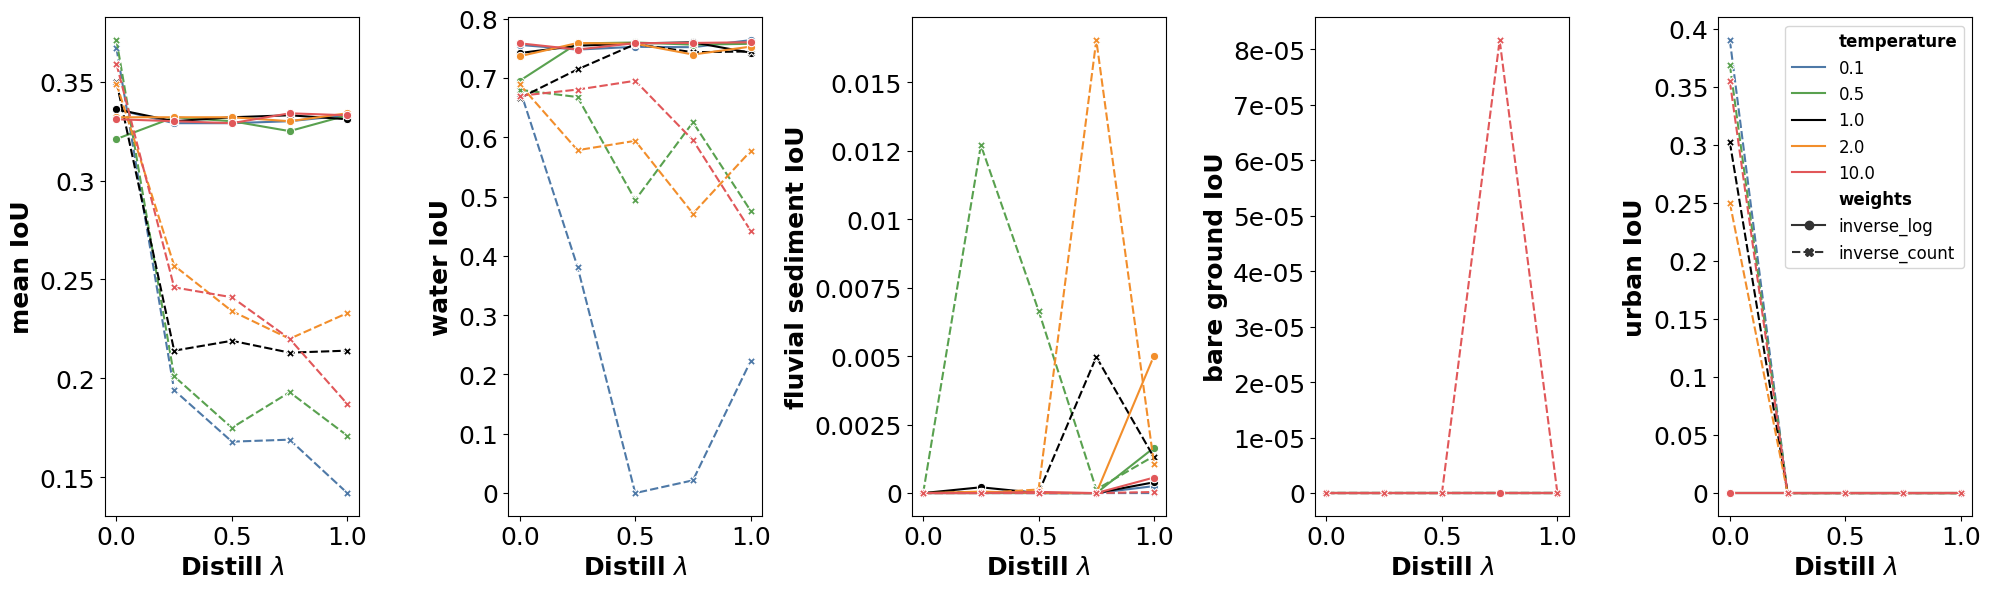

In [341]:
import seaborn as sns
import matplotlib.pyplot as plt

label = 'ESAWC'

sub_df = filtered_df[filtered_df['which_label'] == label]
df1 = sub_df[sub_df['weights'] == 'inverse_log']
df2 = sub_df[sub_df['weights'] == 'inverse_count']

# Define a custom color palette for 'temperature' categories
temperature_palette = ['#4e79a7', '#59a14f','black', '#f28e2b', '#e15759']
sns.set_palette(temperature_palette)

# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 6))

for i, col in enumerate(['mean IoU', 'water IoU', 'fluvial sediment IoU', 'bare ground IoU','urban IoU']):
    sns.lineplot(data=sub_df, x='distill lamda', y=col, hue='temperature', style='weights',
                 markers=True, ax=axes[i], palette=temperature_palette)
    # axes[i].set_title(f'{col}', fontweight='bold')
    axes[i].set_xlabel(r'Distill $\lambda$', fontweight='bold', fontsize=18)
    axes[i].set_ylabel(col, fontweight='bold', fontsize=18)
    axes[i].legend().set_visible(False)  # Remove individual legends

    # Set the font properties for x and y ticks
    axes[i].tick_params(axis='x', labelsize=18)
    axes[i].tick_params(axis='y', labelsize=18)

    # # Make the tick labels bold
    # for tick in axes[i].get_xticklabels():
    #     tick.set_fontweight('bold')
    # for tick in axes[i].get_yticklabels():
    #     tick.set_fontweight('bold')

    # Function to format y-axis ticks to two significant figures
    def format_y_tick(value, _):
        if value == 0:
            return '0'
        else:
            return f'{value:.2g}'  # Format value to two significant figures
        
    # Apply the formatter to the y-axis
    axes[i].yaxis.set_major_formatter(plt.FuncFormatter(format_y_tick))

# Create a common legend outside the subplots
handles, labels = axes[0].get_legend_handles_labels()
legend = plt.legend(handles, labels, title=False, loc='upper right', fontsize=12)  # Set legend font size to 18

# Set the legend labels to bold
for text in legend.get_texts():
    if text.get_text() in ['temperature', 'weights']: 
        text.set_fontweight('bold')

# Adjust layout
plt.tight_layout()


plt.savefig(f'../paper_fig/{label}_T_lamda_lineplots.png', dpi=400)

# Show the plot
plt.show()



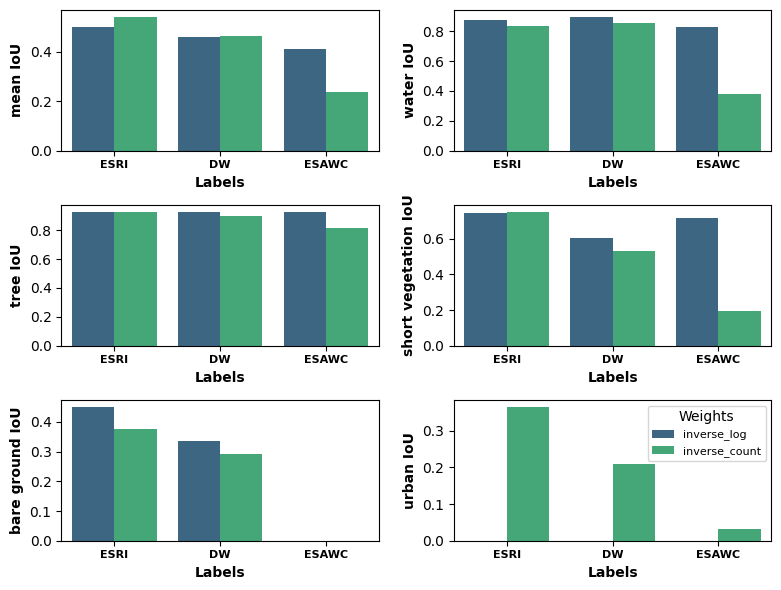

In [306]:
# Plot the accuracy of initial model per land cover class

df_init = df[df['tune_log_num']==0]
# print(df_init)

# Define order of labels and weights
labels_order = ['ESRI', 'DW', 'ESAWC']
weights_order = ['inverse_log', 'inverse_count']

# Define IoU metrics to plot
iou_metrics = ['mean IoU', 'water IoU', 'tree IoU', 'short vegetation IoU', 'bare ground IoU', 'urban IoU']

# Create subplots
num_plots = len(iou_metrics)
cols = 2  # Number of columns in the subplot grid
rows = (num_plots + 1) // cols  # Number of rows in the subplot grid

fig, axes = plt.subplots(rows, cols, figsize=(8, 6))

# Flatten axes if rows > 1
axes = axes.flatten()

for i, metric in enumerate(iou_metrics):
    # Plot grouped bar plot for each metric
    sns.barplot(data=df_init, x='which_label', y=metric, hue='weights',
                order=labels_order, hue_order=weights_order, palette='viridis', ax=axes[i])
    # axes[i].set_title(metric, fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Labels', fontsize=10, fontweight='bold')
    axes[i].set_ylabel(metric, fontsize=10, fontweight='bold')
    axes[i].set_xticklabels(labels_order, fontsize=8, fontweight='bold')

    if i == cols*rows - 1:
        axes[i].legend(title='Weights', fontsize=8, title_fontsize='10', loc='upper right')
    else: 
        axes[i].legend().set_visible(False) 

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [302]:
def format_label(value):
    """Format label by removing leading zero for values between 0 and 1."""
    if value == 0:
        return '0'
    elif value < 0.005:
        return '0'
    else:
        return f'{value:.2f}'

def add_bar_labels(ax):
    """Add labels on top of bars."""
    for p in ax.patches:
        label = format_label(p.get_height())
        ax.annotate(label, (p.get_x() + p.get_width() / 2., p.get_height() + 0.02),
                    ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                    textcoords='offset points', rotation=90)

def plot_group_IoUs(dataframe, ignore_sedi=True, show_legend=True):

    # Filter dataframes based on weights
    df_inverse_log = dataframe[dataframe['weights'] == 'inverse_log']
    df_inverse_count = dataframe[dataframe['weights'] == 'inverse_count']

    landcover_pallete = {
        'mean IoU': 'black',
        'water IoU': '#4183c4',
        'tree IoU': '#009600',
        'short vegetation IoU': '#ccff99',
        'bare ground IoU': '#b4b4b4',
        'urban IoU': '#fa0000',
        'fluvial sediment IoU': '#ffbb22'
    }
    
    wanted_columns = ['which_label', 'mean IoU', 'tree IoU','short vegetation IoU','water IoU', 'urban IoU', 'bare ground IoU', 'fluvial sediment IoU']
    
    if ignore_sedi:
        wanted_columns = wanted_columns[:-1]
    print(wanted_columns)

    # Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), sharey=True)

    # Set different background colors
    axes[0].set_facecolor('#f0f0f0')  # Light gray background for the first subplot
    axes[1].set_facecolor('#e0e0ff')  # Light blue background for the second subplot

    # # Function to add labels on top of bars
    # def add_bar_labels(ax):
    #     for p in ax.patches:
    #         ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()+0.02),
    #                     ha='center', va='center', fontsize=14, color='black', xytext=(0, 5),
    #                     textcoords='offset points', rotation=90)    

    # Plot first subplot (inverse_log)
    ax1 = df_inverse_log[wanted_columns].plot.bar(rot=0, color=landcover_pallete, ax=axes[0], legend=False, alpha=0.8)

    # ax1.set_title('Using inverse-log weights', fontsize=20)
    ax1.set_xticklabels(df_inverse_log['which_label'], fontweight='bold', fontsize=20)
    ax1.set_ylabel('IoU',fontsize=20, fontweight='bold')

    # Set y-axis tick size to 20
    ax1.tick_params(axis='y', which='major', labelsize=20)

    add_bar_labels(ax1)  # Add labels to the bars

    # Plot second subplot (inverse_count)
    ax2 = df_inverse_count[wanted_columns].plot.bar(rot=0, color=landcover_pallete, ax=axes[1], alpha=0.8, legend=False)

    ax2.set_xticklabels(df_inverse_count['which_label'], fontweight='bold', fontsize=20)
    # ax2.set_title('Using inverse-count weights', fontsize=20)

    # Remove top and right spines (outline) from both subplots
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    add_bar_labels(ax2)  # Add labels to the bars

    # Customize the legend font if show_legend is True
    if show_legend:
        # legend = ax2.legend(prop={'size': 20}, framealpha=0.5)  # Change 'size' and 'family' as needed
        handles, labels = ax2.get_legend_handles_labels()
        legend = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,0.08), ncol=4, prop={'size': 20}, framealpha=1)
        legend.get_frame().set_edgecolor('black')
        legend.get_frame().set_linewidth(3) 

        

    # # Determine the comparison line value (e.g., mean of values)
    # water _value = np.mean(values1 + values2)

    # # Draw a horizontal line on both subplots at the comparison value
    # ax1.axhline(comparison_value, color='r', linestyle='--', label='Comparison Line')
    # ax2.axhline(comparison_value, color='r', linestyle='--', label='Comparison Line')

    # Show the plot
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2) 
    plt.show()

['which_label', 'mean IoU', 'tree IoU', 'short vegetation IoU', 'water IoU', 'urban IoU', 'bare ground IoU']


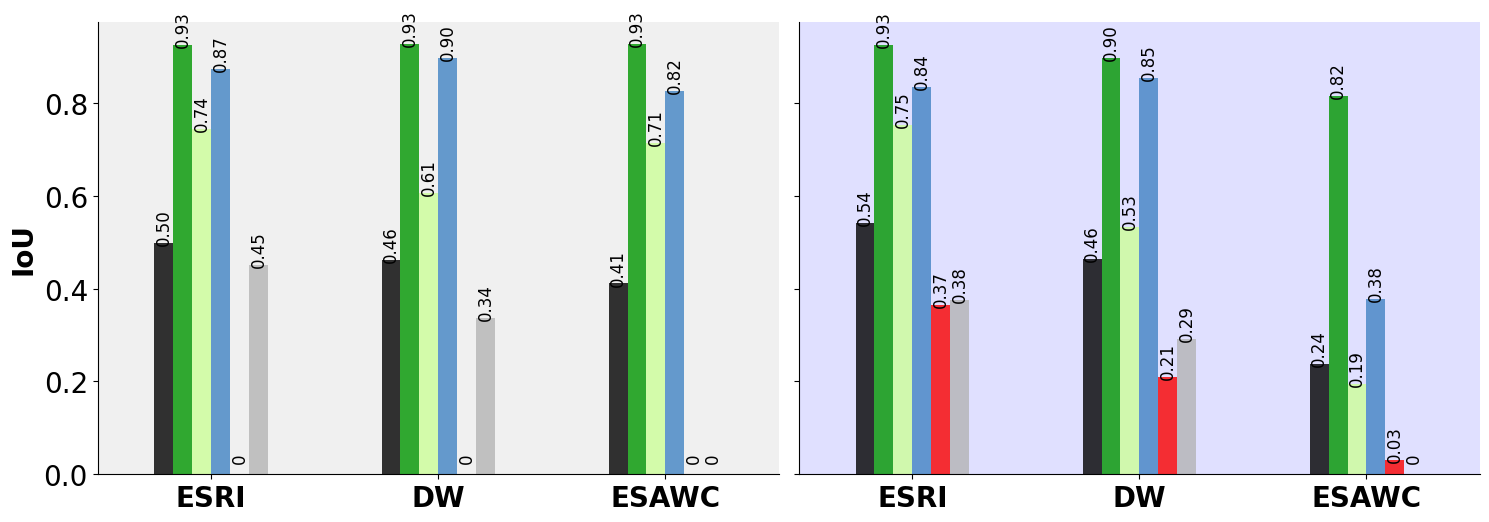

In [292]:
plot_group_IoUs(df_init, show_legend=False)

In [239]:
# Find best models of highest mean IoU.
# Find best models of fine tune only. Exclude the initial trained models
df_ft = df[~df['fluvial sediment IoU'].isna()]

best_miou_idx = df_ft.groupby(by=['which_label', 'weights'])['mean IoU'].idxmax()
df_best_miou = df_ft.loc[best_miou_idx].sort_values(by=['log_num'])

best_water_idx = df_ft.groupby(by=['which_label', 'weights'])['water IoU'].idxmax()
df_best_water = df_ft.loc[best_water_idx].sort_values(by=['log_num'])

best_sedi_idx = df_ft.groupby(by=['which_label', 'weights'])['fluvial sediment IoU'].idxmax()
df_best_sedi = df_ft.loc[best_sedi_idx].sort_values(by=['log_num'])

best_bare_idx = df_ft.groupby(by=['which_label', 'weights'])['bare ground IoU'].idxmax()
df_best_bare = df_ft.loc[best_bare_idx].sort_values(by=['log_num'])

best_urban_idx = df_ft.groupby(by=['which_label', 'weights'])['urban IoU'].idxmax()
df_best_urban = df_ft.loc[best_urban_idx].sort_values(by=['log_num'])

['which_label', 'mean IoU', 'tree IoU', 'short vegetation IoU', 'water IoU', 'urban IoU', 'bare ground IoU', 'fluvial sediment IoU']


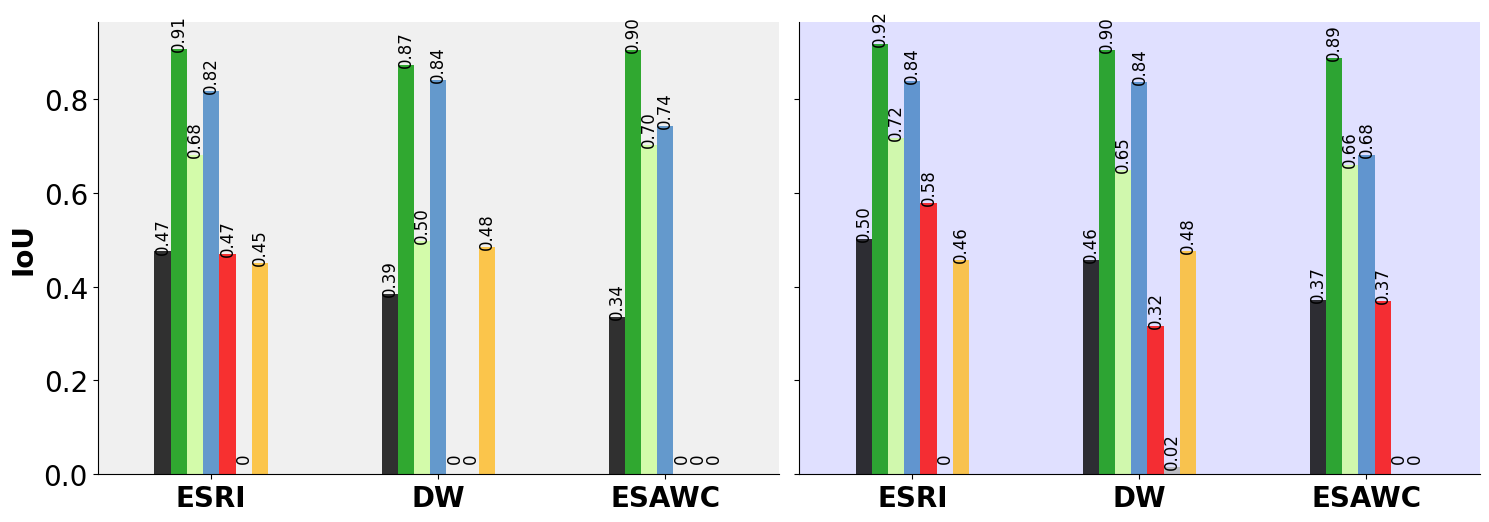

In [293]:
plot_group_IoUs(df_best_miou, ignore_sedi=False, show_legend=False)

['which_label', 'mean IoU', 'tree IoU', 'short vegetation IoU', 'water IoU', 'urban IoU', 'bare ground IoU', 'fluvial sediment IoU']


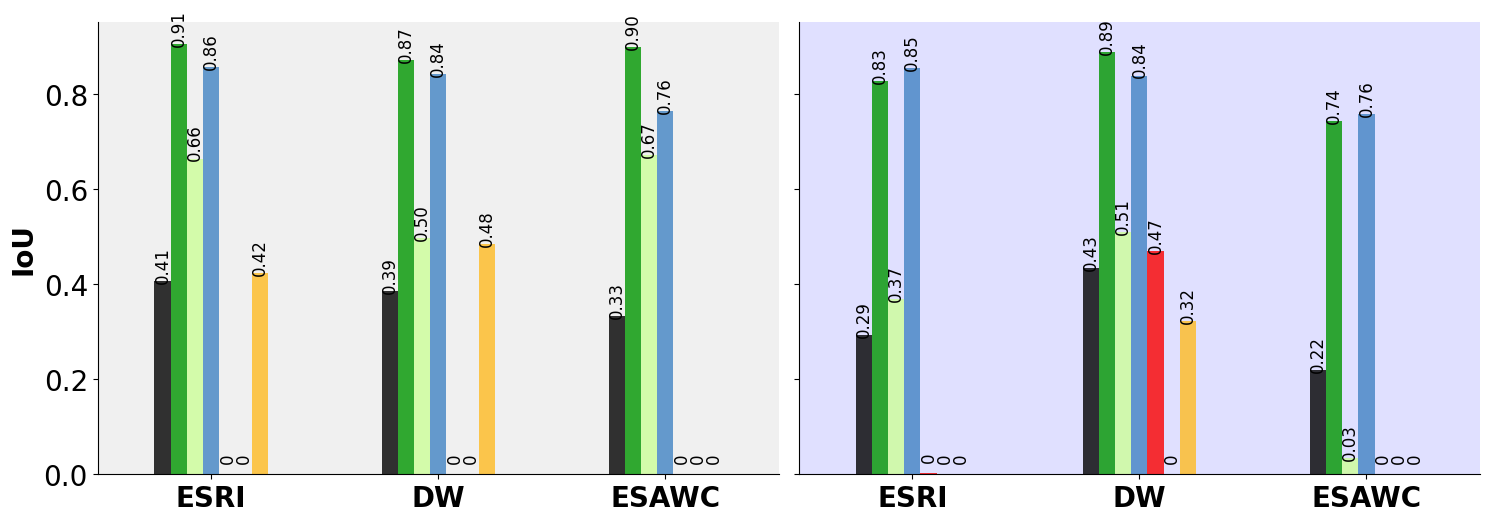

In [367]:
plot_group_IoUs(df_best_water, ignore_sedi=False,show_legend=False)

In [384]:
train_data_csv = '../script/DATA_LAYER/class_percent_weight.csv'
# Read the CSV file into a DataFrame
df = pd.read_csv(train_data_csv)

# Mapping of class labels to descriptive names
class_names = {
    0: 'no data',
    1: 'tree',
    2: 'short vegetation',
    3: 'water',
    4: 'urban',
    5: 'bare ground',
    6: 'fluvial sediment'
}

landcover_palette = {
    'no data': 'black',
    'water': '#4183c4',
    'tree': '#009600',
    'short vegetation': '#ccff99',
    'bare ground': '#b4b4b4',
    'urban': '#fa0000',
    'fluvial sediment': '#ffbb22'
}

# Replace numeric class labels with descriptive names
df['class'] = df['class'].map(class_names)
# Function to format numbers to two significant figures
def format_significant(x):
    return f"{x:.2g}" if pd.notna(x) else 'NA'

# Apply the function to the relevant columns
df['init_pixel_percent'] = df['init_pixel_percent'].apply(lambda x: f"\\textbf{{{format_significant(x)}}}")
df['incre_pixel_percent'] = df['incre_pixel_percent'].apply(lambda x: f"\\textbf{{{format_significant(x)}}}")
df['hand_pixel_percent'] = df['hand_pixel_percent'].apply(lambda x: f"\\textbf{{{format_significant(x)}}}")
df['init_inverse_count'] = df['init_inverse_count'].apply(format_significant)
df['init_inverse_log'] = df['init_inverse_log'].apply(format_significant)
df['incre_inverse_count'] = df['incre_inverse_count'].apply(format_significant)
df['incre_inverse_log'] = df['incre_inverse_log'].apply(format_significant)


df

,which_label,class,init_pixel_percent,init_inverse_count,init_inverse_log,incre_pixel_percent,incre_inverse_count,incre_inverse_log,hand_pixel_percent
0,ESRI,no data,\textbf{6.7e-05},0,0,\textbf{7.8e-05},0,0,\textbf{0.00027}
1,ESRI,tree,\textbf{0.57},0.29,6.1e+06,\textbf{0.7},0.21,1.1e+06,\textbf{0.71}
2,ESRI,short vegetation,\textbf{0.17},0.97,6.5e+06,\textbf{0.14},1.1,1.2e+06,\textbf{0.17}
3,ESRI,water,\textbf{0.25},0.66,6.4e+06,\textbf{0.13},1.1,1.2e+06,\textbf{0.083}
4,ESRI,urban,\textbf{0.0035},48,8.2e+06,\textbf{0.015},9.3,1.3e+06,\textbf{0.011}
5,ESRI,bare ground,\textbf{0.006},28,7.9e+06,\textbf{0.00092},1.6e+02,1.7e+06,\textbf{0.0062}
6,ESRI,fluvial sediment,\textbf{NA},NA,NA,\textbf{0.024},6,1.3e+06,\textbf{0.014}
7,DW,no data,\textbf{0.042},0,0,\textbf{0.038},0,0,\textbf{0.00027}
8,DW,tree,\textbf{0.56},0.3,5e+06,\textbf{0.71},0.2,1.1e+06,\textbf{0.71}
9,DW,short vegetation,\textbf{0.13},1.3,5.4e+06,\textbf{0.088},1.6,1.2e+06,\textbf{0.17}


In [396]:
# Group by 'which_label' and iterate over each group
labels = df['which_label'].unique()

# LaTeX table generation
for label in labels:
    print(f"\\begin{{table}}[htbp]")
    print(f"\\centering")
    print(f"\\caption{{The pixel percentage (PP) and weight functions for  of labels from {label} per land cover class in initial train set, fine tune train set and test set. The ILW means \"inverse log weight\", and the \"ICW\" means \"inverse count weight\".}}")
    print(f"\\begin{{tabular}}{{|c|c|c|c|c|c|c|c|}}")
    print(f"\\hline")
    print(f"\\textbf{{Class}} & \\textbf{{Init PP}} & \\textbf{{Init ICW}} & \\textbf{{Init ILW}} & \\textbf{{Finetune PP}} & \\textbf{{Finetune ICW}} & \\textbf{{Finetune ILW}} & \\textbf{{Test PP}} \\\\")
    print(f"\\hline")
    
    group_df = df[df['which_label'] == label]

    for index, row in group_df.iterrows():
        init_pixel_percent = row['init_pixel_percent']
        init_inverse_count = row['init_inverse_count']
        init_inverse_log = row['init_inverse_log']
        incre_pixel_percent = row['incre_pixel_percent']
        incre_inverse_count = row['incre_inverse_count']
        incre_inverse_log = row['incre_inverse_log']
        hand_pixel_percent = row['hand_pixel_percent']
        
        print(f"{row['class']} & {init_pixel_percent} & {init_inverse_count} & {init_inverse_log} & {incre_pixel_percent} & {incre_inverse_count} & {incre_inverse_log} & {hand_pixel_percent} \\\\")
        print(f"\\hline")
    
    print(f"\\end{{tabular}}")
    print(f"\\end{{table}}")
    print()

\begin{table}[htbp]
\centering
\caption{The pixel percentage (PP) and weight functions for  of labels from ESRI per land cover class in initial train set, fine tune train set and test set. The ILW means "inverse log weight", and the "ICW" means "inverse count weight".}
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\textbf{Class} & \textbf{Init PP} & \textbf{Init ICW} & \textbf{Init ILW} & \textbf{Finetune PP} & \textbf{Finetune ICW} & \textbf{Finetune ILW} & \textbf{Test PP} \\
\hline
no data & \textbf{6.7e-05} & 0 & 0 & \textbf{7.8e-05} & 0 & 0 & \textbf{0.00027} \\
\hline
tree & \textbf{0.57} & 0.29 & 6.1e+06 & \textbf{0.7} & 0.21 & 1.1e+06 & \textbf{0.71} \\
\hline
short vegetation & \textbf{0.17} & 0.97 & 6.5e+06 & \textbf{0.14} & 1.1 & 1.2e+06 & \textbf{0.17} \\
\hline
water & \textbf{0.25} & 0.66 & 6.4e+06 & \textbf{0.13} & 1.1 & 1.2e+06 & \textbf{0.083} \\
\hline
urban & \textbf{0.0035} & 48 & 8.2e+06 & \textbf{0.015} & 9.3 & 1.3e+06 & \textbf{0.011} \\
\hline
bare ground & \textbf{